## Basic API of AutoKeras

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak
from tensorflow.keras import layers, models, datasets
tf.random.set_seed(42)

In [2]:
# This fix an issue with TensorFlow 2.4.1 reported here https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Load the dataset

Download the CIFAR1O dataset.
The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [83]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Verify some images

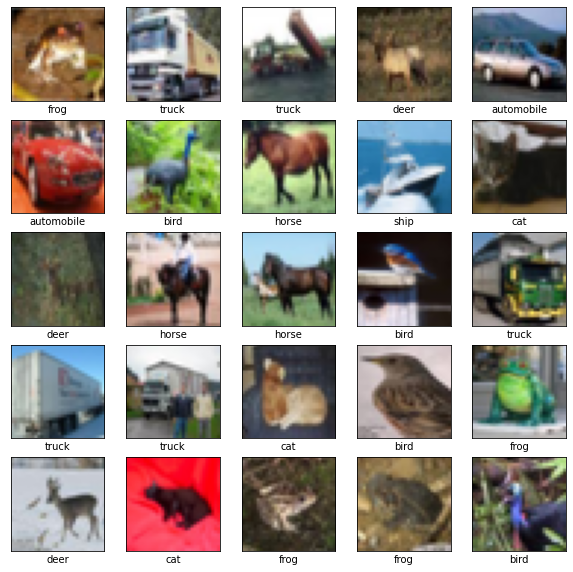

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## AutoKeras task

Build the automated image classification using the AutoKeras Functional API.

In [7]:
# Initialize the image classifier.
clf = ak.ImageClassifier(max_trials=1)

In [9]:
# Feed the image classifier with training data
clf.fit(x_train, y_train, epochs=10)

Trial 1 Complete [00h 02m 34s]
val_loss: 0.8866374492645264

Best val_loss So Far: 0.8866374492645264
Total elapsed time: 00h 02m 34s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1563/1563 [==============================] - 14s 7ms/step - loss: 1.5567 - accuracy: 0.4457
Epoch 2/10
1563/1563 [==============================] - 9s 5ms/step - loss: 1.0857 - accuracy: 0.6201
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9885 - accuracy: 0.6525
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9214 - accuracy: 0.6764
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8763 - accuracy: 0.6963
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8488 - accuracy: 0.7027
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8175 - accuracy: 0.7122
Epoch 8/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7919 - accuracy: 0.7252
Epoch 9/10


## Predict the model

In [10]:
# Predict with the best model, the class of the test image
predicted_y = clf.predict(x_test)
print(predicted_y)

313/313 [==============================] - 1s 2ms/step
[['3']
 ['8']
 ['8']
 ...
 ['3']
 ['0']
 ['7']]


## Evaluate the model

In [11]:
# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

313/313 [==============================] - 1s 4ms/step - loss: 0.8272 - accuracy: 0.7143
[0.8272292017936707, 0.7142999768257141]


In [12]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0     

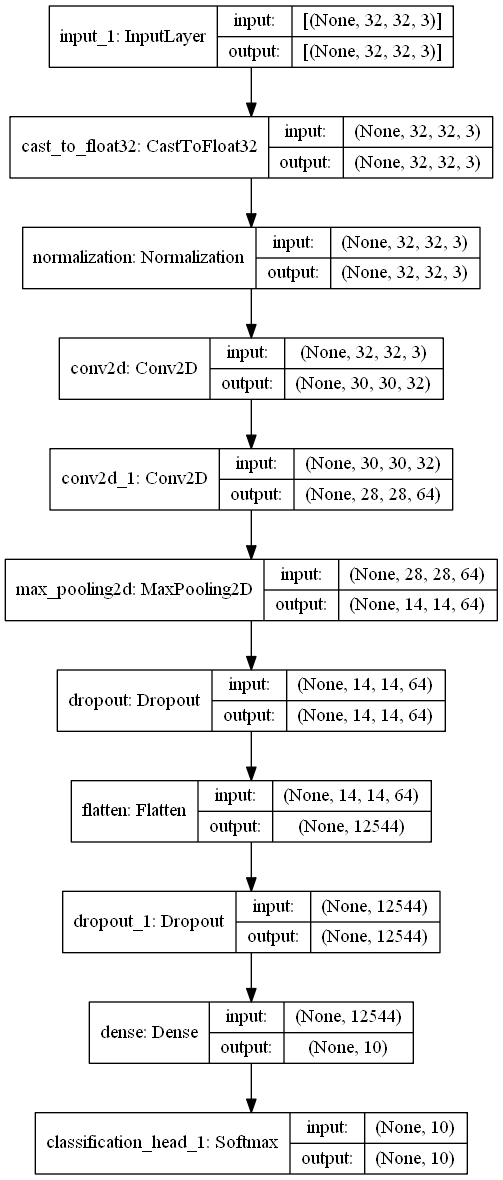

In [13]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Auto Keras also accepts different data format, such as numpy arrays, pandas dataframes, and tf.data.Dataset.

In [16]:
print(x_train.shape)  # (60000, 28, 28, 1)
print(y_train.shape)  # (60000, 10)
print(y_train[:3])

(50000, 32, 32, 3, 1)
(50000, 10)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
train_set = tf.data.Dataset.from_tensor_slices(((x_train,), (y_train,)))
test_set = tf.data.Dataset.from_tensor_slices(((x_test,), (y_test,)))

In [7]:
train_set = train_set.shuffle(buffer_size=16).batch(16).repeat()
test_set = test_set.batch(16)

In [8]:
partial_train_set=train_set.take(5000)

In [9]:
clf = ak.ImageClassifier(max_trials=2)
# Feed the tensorflow dataset to the image classifier
clf.fit(partial_train_set, epochs=5)
# Predict with the best model, the class of the test image
predicted_y = clf.predict(test_set)
print(predicted_y)

Trial 1 Complete [05h 17m 34s]
val_loss: 1.2337389886379242

Best val_loss So Far: 0.757867693901062
Total elapsed time: 05h 17m 34s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
5000/5000 [==============================] - 359s 58ms/step - loss: 2.4605 - accuracy: 0.0995
Epoch 2/5
5000/5000 [==============================] - 290s 58ms/step - loss: 2.3306 - accuracy: 0.0980
Epoch 3/5
5000/5000 [==============================] - 289s 58ms/step - loss: 2.3142 - accuracy: 0.1000
Epoch 4/5
5000/5000 [==============================] - 289s 58ms/step - loss: 2.3096 - accuracy: 0.0982
Epoch 5/5
5000/5000 [==============================] - 289s 58ms/step - loss: 2.3058 - accuracy: 0.0979
INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets
625/625 [==============================] - 10s 16ms/step
[['5']
 ['4']
 ['5']
 ...
 ['1']
 ['5']
 ['4']]


In [14]:
# Get the summarized results
clf.tuner.results_summary()

Results summary
Results in .\image_classifier
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
image_block_1/block_type: resnet
image_block_1/normalize: True
image_block_1/augment: True
image_block_1/image_augmentation_1/horizontal_flip: True
image_block_1/image_augmentation_1/vertical_flip: True
image_block_1/image_augmentation_1/contrast_factor: 0.0
image_block_1/image_augmentation_1/rotation_factor: 0.0
image_block_1/image_augmentation_1/translation_factor: 0.1
image_block_1/image_augmentation_1/zoom_factor: 0.0
image_block_1/res_net_block_1/pretrained: False
image_block_1/res_net_block_1/version: resnet50
image_block_1/res_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: global_avg
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 0.001
Score: 0.757867693901062
Trial summary
Hyperparameters:
image_block_1/block_type: vanilla
image_block_1/normalize: True
image_block_1/augment: Fa

In [16]:
# Get the best model
best_model = clf.export_model()
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 32, 32, 3)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 3)         7         
_________________________________________________________________
random_translation (RandomTr (None, 32, 32, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 32, 32, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        235877

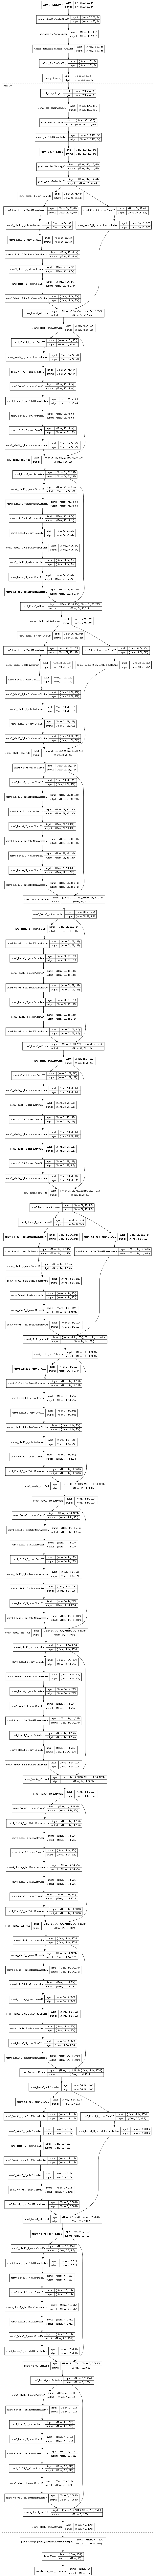

In [20]:
# Display the best model
tf.keras.utils.plot_model(best_model, to_file='best_model.png', show_shapes=True, expand_nested=True, dpi=64)

In [85]:
# Save model to a file
try:
    best_model.save("model_autokeras", save_format="tf")
except Exception:
    best_model.save("model_autokeras.h5")

INFO:tensorflow:Assets written to: model_autokeras\assets


In [86]:
# Load model from a file
from tensorflow.keras.models import load_model
loaded_model = load_model("model_autokeras", custom_objects=ak.CUSTOM_OBJECTS)

## Configure the search process using different hyperparameters

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [77]:
x_train_r = x_train[:1000]
y_train_r = y_train[:1000]
# Create dataset
train_set = tf.data.Dataset.from_tensor_slices(((x_train_r,), (y_train_r,)))
test_set = tf.data.Dataset.from_tensor_slices(((x_test,), (y_test,)))

In [5]:
# Create dataset
train_set = tf.data.Dataset.from_tensor_slices(((x_train_r,), (y_train,)))
test_set = tf.data.Dataset.from_tensor_slices(((x_test_r,), (y_test,)))

In [78]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_set.cache().shuffle(1000).batch(16).prefetch(buffer_size=AUTOTUNE)
train_ds

<PrefetchDataset shapes: (((None, 32, 32, 3),), ((None, 1),)), types: ((tf.float64,), (tf.uint8,))>

In [79]:
clf = ak.ImageClassifier(max_trials=2,
    overwrite=False,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    objective='val_accuracy')

INFO:tensorflow:Reloading Oracle from existing project .\image_classifier\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\image_classifier\oracle.json


INFO:tensorflow:Reloading Tuner from .\image_classifier\tuner0.json


INFO:tensorflow:Reloading Tuner from .\image_classifier\tuner0.json


In [80]:
# Feed the tensorflow dataset to the image classifier
clf.fit(train_ds,
    epochs=10,
    validation_split=0.15,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./autokeras_tensorboard')],
    verbose=1)

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
Not enough memory, reduce batch size to 8.
Epoch 1/10
125/125 [==============================] - 72s 577ms/step - loss: 2.3446 - accuracy: 0.0770
Epoch 2/10
125/125 [==============================] - 55s 437ms/step - loss: 2.3308 - accuracy: 0.1060
Epoch 3/10
125/125 [==============================] - 57s 454ms/step - loss: 2.3305 - accuracy: 0.1170
Epoch 4/10
125/125 [==============================] - 55s 440ms/step - loss: 2.3256 - accuracy: 0.0980
Epoch 5/10
125/125 [==============================] - 56s 448ms/step - loss: 2.3214 - accuracy: 0.1110
Epoch 6/10
125/125 [==============================] - 56s 444ms/step - loss: 2.3162 - accuracy: 0.1080
Epoch 7/10
125/125 [==============================] - 56s 448ms/step - loss: 2.3377 - accuracy: 0.1050
Epoch 8/10
125/125 [==============================] - 54s 430ms/step - loss: 2.3247 - accuracy: 0.1060
Epoch 9/10
125/125 [==============================] - 53s 427ms/step - loss: 2.3179 - accuracy: 0.0990
Epoch 10/10
125/125

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


In [81]:
# make prediction and plot the results
y_predictions = clf.predict( x_test[:32] ).argmax(axis = 1)

1/1 [==============================] - 0s 231ms/step


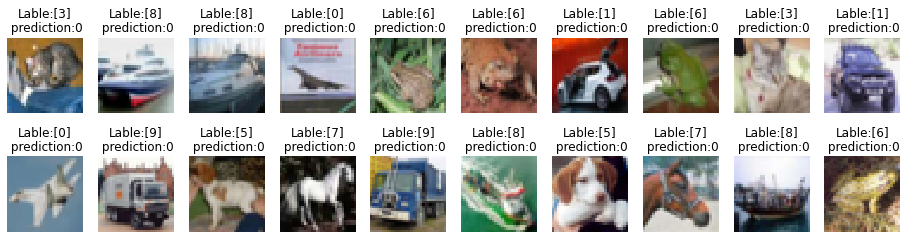

In [82]:
plt.figure( figsize=(16,4) )
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(x_test[i].reshape(32,32,3), cmap='gray', interpolation='none')
    plt.title("Lable:{}\n prediction:{}".format(y_test[i], y_predictions[i]))
    plt.axis('off')